<div class="alert alert-block alert-info">
<b>Deadline:</b> April 27, 2022 (Wednesday) 23:00
</div>

# Exercise 1. Bottleneck autoencoders

The goal of this exercise is to get familiar with bottleneck autoencoders.

In [150]:
skip_training = True  # Set this flag to True before validation and submission

In [151]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [152]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [153]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [154]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')
if torch.cuda.is_available():
    device = "cuda:0"

In [155]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

In this exercise, we use the standard MNIST data.

In [156]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Minmax normalization to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

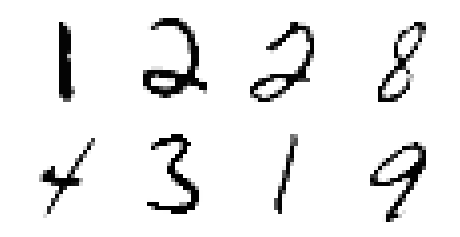

In [157]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Train a deep autoencoder

We train a deep autoencoders with only fully-connected layers.

## Encoder

Our encoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with `n_components` outputs

In [158]:
class Encoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in produced encodings.
        """
        super(Encoder, self).__init__()
        self.n_components= n_components
        self.net = nn.Sequential(nn.Linear(28*28, 1000),
                                    nn.ReLU(),
                                    nn.Linear(1000, 500),
                                    nn.ReLU(),
                                    nn.Linear(500,250),
                                    nn.ReLU(),
                                    nn.Linear(250, n_components)).to(device)

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, n_channels=1, width, height): Examples to encode.

        Returns:
          z of shape (batch_size, n_components): Produced encodings.
        """
        x = x.to(device)
        z = torch.empty(size=(x.shape[0], self.n_components), device = device)
        for i, batch in enumerate(x):
          z[i] = self.net(batch.view(-1))
        return z

In [159]:
def test_Encoder_shapes():
    n_components = 2
    encoder = Encoder(n_components)
    
    x = torch.randn(3, 1, 28, 28)
    y = encoder(x)
    assert y.shape == torch.Size([3, n_components]), f"Bad y.shape: {y.shape}"
    print('Success')

test_Encoder_shapes()

Success


## Decoder

Our decoder will have three hidden layers with ReLU nonlinearities. The exact architecture is not tested. We used the following architecture in our experiments:
- a fully-connected layer with 250 units followed by ReLU nonlinearity
- a fully-connected layer with 500 units followed by ReLU nonlinearity
- a fully-connected layer with 1000 units followed by ReLU nonlinearity
- a fully-connected layer with 784 outputs

In [160]:
class Decoder(nn.Module):
    def __init__(self, n_components):
        """
        Args:
          n_components (int): Number of elements in input codes.
        """
        super(Decoder, self).__init__()
        self.n_components= n_components
        self.net = nn.Sequential(nn.Linear(n_components, 250),
                                    nn.ReLU(),
                                    nn.Linear(250, 500),
                                    nn.ReLU(),
                                    nn.Linear(500,1000),
                                    nn.ReLU(),
                                    nn.Linear(1000, 28*28)).to(device)

    def forward(self, z):
        """
        Args:
          z of shape (batch_size, n_components): Codes to decode.

        Returns:
          xrec of shape (batch_size, n_channels=1, width, height): Reconstructions computed from the given codes.
        """
        z = z.to(device)
        xrec = torch.empty(size=(z.shape[0],1,28,28), device = device)
        for i, batch in enumerate(z):
          xrec[i] = self.net(batch).view(1,28,28)
        
        return xrec

In [161]:
def test_Decoder_shapes():
    n_components = 2
    decoder = Decoder(n_components)
    
    z = torch.randn(3, n_components)
    y = decoder(z)
    assert y.shape == torch.Size([3, 1, 28, 28]), "Bad shape of y: y.shape={}".format(y.shape)
    print('Success')

test_Decoder_shapes()

Success


# Train a bottleneck autoencoder

We will use the bottleneck autoencoder to encode MNIST images into 10-dimensional representations.

In [162]:
# Create a deep autoencoder
n_components = 10
encoder = Encoder(n_components)
encoder.to(device)

decoder = Decoder(n_components)
decoder.to(device)

Decoder(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1000, out_features=784, bias=True)
  )
)

### Training loop

Implement the training loop in the cell below. In the training loop, the training data are first encoded into lower-dimensional representations using the encoder. Then, the decoder is used to produce the reconstructions of the original images from the lower-dimensional code. We will use the `MSELoss` to measure the reconstruction error, which is minimized during training.

The recommended hyperparameters:
* Adam optimizer with learning rate 0.001

Hints:
- Training usually converges fast, four epochs is usually enough.
- The loss at convergence should be close to 0.066.

In [163]:
# Training loop
if not skip_training:
    import time
    
    def print_error(epoch, error, total, start):
        print(f"Epoch {epoch}: Average loss is {np.round(error/total, decimals = 4)}")
        print(f"         after {np.round((time.time() - start)/60, decimals = 1)} min")
        
    epochs = 4
    encoder_params = encoder.parameters()
    decoder_params = decoder.parameters()
    encoder_optimizer = torch.optim.Adam(encoder_params, lr=0.001)
    decoder_optimizer = torch.optim.Adam(decoder_params, lr=0.001)
    criterion = nn.MSELoss()
    
    start = time.time()
    for i in range(epochs):
        encoder.train()
        decoder.train()
        total = 0
        error = 0
        for data, _ in trainloader:
            data = data.to(device)
            #labels = labels.to(device)
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoded = encoder(data)
            decoded = decoder(encoded)
            
            loss = criterion(decoded, data)
            
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
            total += 1
            error += loss.item()
        print_error(i+1, error, total, start)
    end = time.time()
    print("Training done")
    print("Time needed: ", (end - start)/60, "min")

Epoch 1: Average loss is 0.1497
         after 1.6 min
Epoch 2: Average loss is 0.086
         after 3.3 min
Epoch 3: Average loss is 0.0741
         after 5.0 min
Epoch 4: Average loss is 0.0685
         after 6.7 min
Training done
Time needed:  6.6698553164800005 min


In [164]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(encoder, '1_ae_encoder.pth', confirm=True)
    tools.save_model(decoder, '1_ae_decoder.pth', confirm=True)

Model saved to 1_ae_encoder.pth.
Model saved to 1_ae_decoder.pth.


In [165]:
if skip_training:
    encoder = Encoder(n_components=10)
    tools.load_model(encoder, '1_ae_encoder.pth', device)

    decoder = Decoder(n_components=10)
    tools.load_model(decoder, '1_ae_decoder.pth', device)

### Visualize embeddings

Let us visualize the latent space in the cell below. If your autoencoder does a good job, you should clearly see ten clusters corresponding to the ten classes.

Use t-SNE


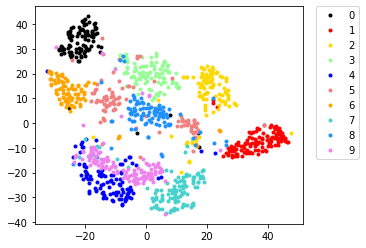

In [166]:
tests.visualize_embeddings(encoder, trainloader, n_samples=1000, device=device)

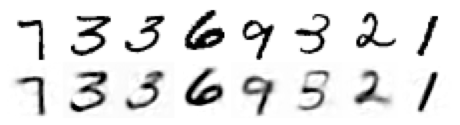

In [167]:
# Let's visualize test images and their reconstructions using the trained autoencoder
tests.visualize_reconstructions(encoder, decoder, trainloader, device=device)

## Test the quality of the produced embeddings by classification

We will test the quality of the produced encodings by training a classifier using the encoded images.

In [168]:
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [169]:
# Encode data samples using the encoder
def encode(dataset, encoder):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)
    with torch.no_grad():
        embeddings = []
        labels = []
        for images, labels_ in dataloader:
            embeddings.append(encoder(images.to(device)))
            labels.append(labels_)

        embeddings = torch.cat(embeddings, dim=0)
        labels = torch.cat(labels, dim=0)
    return embeddings, labels

In [170]:
# Save and submit the AE embeddings
if not skip_training:
    traincodes, trainlabels = encode(trainset, encoder)  # traincodes is (60000, 10)
    testcodes, testlabels = encode(testset, encoder)  # testcodes is (10000, 10)
    torch.save([traincodes, trainlabels, testcodes, testlabels], '1_ae_embeddings.pth')
else:
    traincodes, trainlabels, testcodes, testlabels = torch.load('1_ae_embeddings.pth', map_location=lambda storage, loc: storage)

In [171]:
# Train a simple linear classifier
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
logreg.fit(traincodes.cpu(), trainlabels.cpu())

predicted_labels = logreg.predict(testcodes.cpu())  # (10000,)

accuracy = np.sum(testlabels.cpu().numpy() == predicted_labels) / predicted_labels.size
print('Accuracy with a linear classifier: %.2f%%' % (accuracy*100))
assert accuracy > .85, "Poor accuracy of the embeddings: classification accuracy is %.2f%%" % (accuracy*100)
print('Success')

Accuracy with a linear classifier: 90.81%
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we reduced the dimensionality of the MNIST data from $28 \times 28 = 784$ to $10$ using a bottleneck autoecoder. Using a very simple linear classifier, we were able to classify the encoded images with a good accuracy, which is the evidence that the structure of the data is well preserved in the embedding space.